In [1]:
from fpla.utils import load_config
from fpla import features 
from fpla.model import rmse, plot_predictions
import pandas as pd
import numpy as np
from pathlib import Path 
import sqlite3 
from itertools import islice

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, ParameterGrid
import rfpimp
from treeinterpreter import treeinterpreter as ti

import matplotlib.pyplot as plt 
import seaborn as sns
from pdpbox import pdp, info_plots

%matplotlib inline
%load_ext autoreload 
%autoreload 2 

CONFIG_PATH = Path('../sources-config.json')

In [2]:
config = load_config(CONFIG_PATH)
db_con = sqlite3.connect(config['db_connection'])

## Load data

Loading main dataframe and auxiliary dataframes used for extracting/engineering features.

We also need to de-duplicate double gameweeks as we will have the same ownership values for both matches, and will aggregate the values which are not unique within a single player/gameweek combination (e.g. points).

In [3]:
df = pd.read_sql('select * from fpl_player_2017', con=db_con)
df_match = pd.read_sql('select * from fpl_match_2017', con=db_con, parse_dates=['deadline_time','kickoff_time'])
df_status = pd.read_sql('select * from fpl_status_2017', con=db_con, parse_dates=['status_date'])

# storing auxiliary dataframes in a dict to easily pass as paramters
dfs = {
    'df_match': df_match, 
    'df_status': df_status,
}
        
# columns to group by (constant at gameweek level)
group_columns = [
    'player_id', 
    'player_name', 
    'gw', 
    'selected', 
    'value', 
    'pos', 
    'transfers_balance', 
    'team_name',
    'team_id' 
] 

# columns to aggregate over in a single gameweek
agg_columns = {
    'points': 'sum', 
    'minutes': 'sum', 
    'gw_match': 'max' 
} 
  
columns = group_columns + list(agg_columns.keys())  
      
# deduplicate double gameweeks (move from gameweek/match records to gameweek records)
df = (df.loc[:, columns]
        .groupby(group_columns, as_index=False) 
        .agg(agg_columns)
        .sort_values(['player_id', 'gw']))

## Objective

As outlined in the previous notebook we will be training a model that predicts player ownership in Fantasy Premier League.

Since initially proposing `selected` (total number of teams owning a player in a single gamweek) as our target variable, we will now be predicting `transfers_balance` (transfers in - transfers out in a single gameweek). 

The two variables are directly correlated as `transfers_balance` is simply the difference in `selected` between consecutive weeks so all of our previous findings (and shortfalls) are still valid. The reason for changing the variable is that looking at the change in a single week (rather than the total) hopefully gives us a few benefits:
* Easier to intepret plots as positive/negative `transfers_balance` means the same for all players, wherease `selected` needs to be considered in the context of the scale of a particular series.
* If we were to use `selected` the model would be entirely dependent on interactions with `selected` from the previous week as that would scale our prediction, before considering effects of other variables. While the scale of `selected` should also impact `transfers_balance`, it should hopefully be less important. For example if a player scores lots of points we would expect `transfers_balance` to be positive, whilst as a secondary effect we may expect the magnitude of that increase to depend on how many players already owns that player (i.e. `selected`).

Initial approach adapted from [Mario Filho](http://mariofilho.com/how-to-predict-multiple-time-series-with-scikit-learn-with-sales-forecasting-example/) blog with other influences from the **fastai** lecture series.

Plotting a comparison between `selected` and `transfers_balance` for a single player.

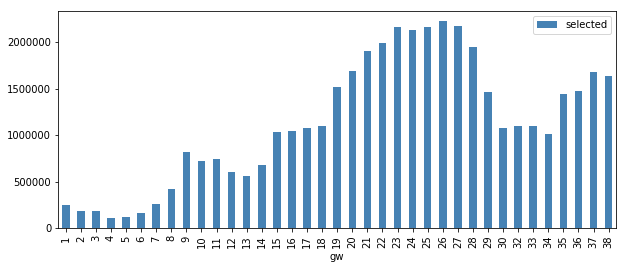

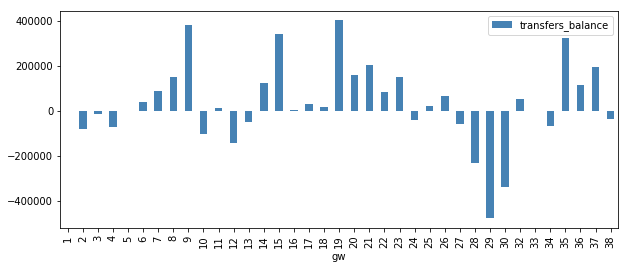

In [4]:
df_sample = df.loc[df['player_name'] == 'raheem sterling']

df_sample.plot.bar(x='gw', y='selected', figsize=(10,4), color='steelblue')
df_sample.plot.bar(x='gw', y='transfers_balance', figsize=(10,4), color='steelblue')
plt.show()

## Features

Append **"lagged"** version of input variables, by looking at (`gameweek` - n) where n in a given offset

In [5]:
df = features.append_lags(df, 'selected', offsets=[1,2])
df = features.append_lags(df, 'transfers_balance', offsets=[1,2])
df = features.append_lags(df, 'points', offsets=[1,2])
df = features.append_lags(df, 'value', offsets=[1,2])

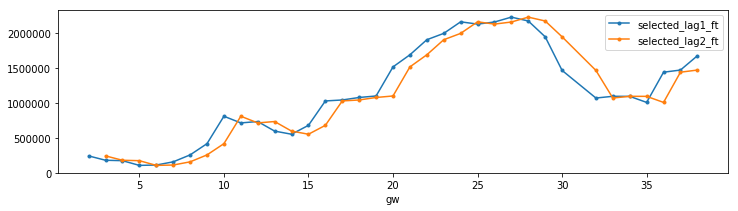

In [6]:
(df.loc[df['player_name'] == 'raheem sterling']
   .plot.line(x='gw', y=['selected_lag1_ft','selected_lag2_ft'], style='.-', figsize=(12,3)))
plt.show()

Append **"diff"** version of input variables. This is like "lag" but we subtract the values between consecutive (`gameweek` - n) and (`gameweek` - n - 1) rather than just taking the raw value

In [7]:
df = features.append_diffs(df, 'transfers_balance', offsets=[1,2])
df = features.append_diffs(df, 'value', offsets=[1])

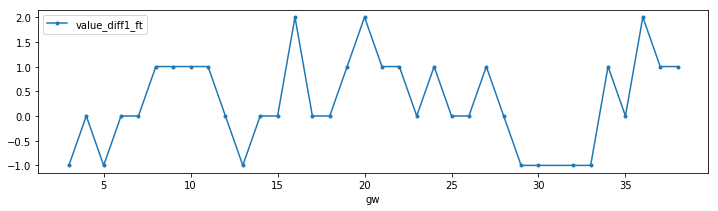

In [8]:
(df.loc[df['player_name'] == 'raheem sterling']
   .plot.line(x='gw', y='value_diff1_ft', style='.-',figsize=(12,3)))
plt.show()

Append column to indicate a player has a **double gameweek** (`double_gw_ft`)

In [9]:
df = features.append_double_gw(df)

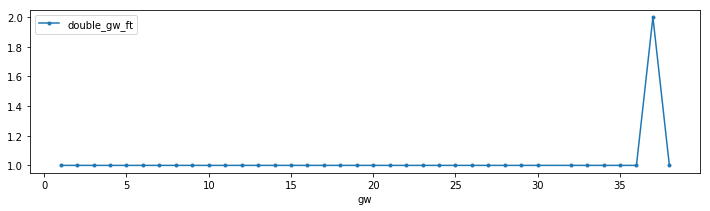

In [10]:
(df.loc[df['player_name'] == 'raheem sterling']
   .plot.line(x='gw', y='double_gw_ft', style='.-', figsize=(12,3)))
plt.show()

Append column which counts the **number of teams playing a gameweek**, this should hopefully benefit players playing in gameweeks which have fewer matches i.e. when some players do not have a match, the other players which do should see an increase in transfers (`gw_match_ft`)

In [11]:
df = features.append_gw_teams(df, df_match)

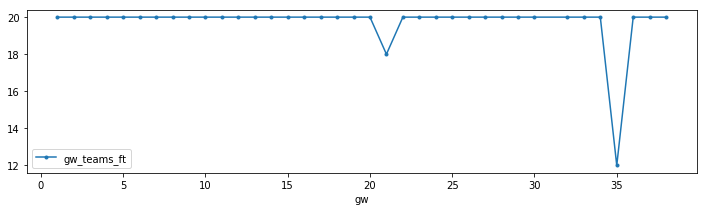

In [12]:
(df.loc[df['player_name'] == 'raheem sterling']
   .plot.line(x='gw', y='gw_teams_ft', style='.-', figsize=(12,3)))
plt.show()

Append player status to DataFrame. This will create three new columns
* `status`: This is the status of a player, possible values are 'a': available, 'i': injured, 's': suspended, 'l': loan and 'u': unavailable
* `prob`: Probability of a player playing in the next match, possible values are 0, 25, 50, 75 and 100
* `step`: The index of the current status relative to all status updates available for that player

Whilst these will not be used as features directly, we will use them engineer other features

In [13]:
df = features.append_player_status(df, **dfs) 

First we convert `status` into `status_type` where we group positive statuses as 1 and negative statuses as 0

In [14]:
df = features.append_status_type(df) 

Finally we create two features:

* Feature which counts the **number of consecutive weeks of status type** (`st1_run_ft` and `st0_run_ft`)
* Feature which indicates a **change in status type** (`st_change_ft`) where 1 is a positive change in status, 0 is not change in status and -1 is a negative change in status

In theory the `st_change_ft` flag will predict a strong response in transfers activity as a player moves from injury/suspension to availability or vice-versa.

The effect of `st1_run_ft` and `st0_run_ft` is less predictable as we would expect a longer run of consecutive weeks as injured/suspended to increase the change that people will react, but at the same time, the longer the run the fewer people will have *not* reacted and so the effect may diminish, but hopefully the Random Forest will be able to calculate any non-linearities. The change from 0 to 1 may also work as a proxy for `st_change_ft` so we may end up dropping one of these features.

In [15]:
df = features.append_status_type_run(df) 
df = features.append_status_type_change(df) 

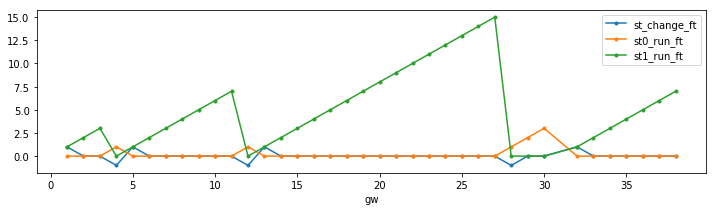

In [16]:
(df.loc[df['player_name'] == 'raheem sterling']
   .plot.line(x='gw', y=['st_change_ft', 'st0_run_ft', 'st1_run_ft'], style='.-', figsize=(12,3)))
plt.show()

We add the player position, encoded as an ordinal variable. This could be one-hot encoded but it may be possible that a simple split on goalkeeper/defender vs midfielder/forward will be sufficient for the model. If further splits to individual positions are required the model can handle this. 

In [17]:
df = features.append_ordinal(df, 'pos', order=['g','d','m','f']) 

Finally we rename our target variable to be more succint, and create a random feature which will be used as baseline in feature importance

In [18]:
df['y'] = df['transfers_balance'] 
df['random_ft'] = np.random.random(size=len(df))

List all our feature columns which are indiciated with the '_ft' suffix

In [19]:
feature_columns = df.columns[df.columns.str.endswith('_ft')].tolist()

feature_columns

['double_gw_ft',
 'selected_lag1_ft',
 'selected_lag2_ft',
 'transfers_balance_lag1_ft',
 'transfers_balance_lag2_ft',
 'points_lag1_ft',
 'points_lag2_ft',
 'value_lag1_ft',
 'value_lag2_ft',
 'transfers_balance_diff1_ft',
 'transfers_balance_diff2_ft',
 'value_diff1_ft',
 'gw_teams_ft',
 'st1_run_ft',
 'st0_run_ft',
 'st_change_ft',
 'pos_ft',
 'random_ft']

The offset features (lag/diff) have introduce some null values for the initial gameweeks where we don't have enough history. We will drop these columns from our training data for now, but can explore null replacement strategies later on.

We also drop players which don't meet an (abitrary) minimum threshold for `selected` as we are not interested in predicting these players with almost no ownership. Also they will artificially reduce the overall error as some intitial tests show that that they are being predicted correctly (as zero) simply because they have no activity. 

In [20]:
print(df.shape)

df = df.dropna(subset=feature_columns) 
print(df.shape)

subset = df.groupby('player_id').filter(lambda x: x['selected'].max() > 2500)['player_id'].unique() 
df = df.loc[df['player_id'].isin(subset)] 
print(df.shape)

df.reset_index(drop=True, inplace=True) 

(21797, 35)
(19861, 35)
(17607, 35)


## Evaluation

#### Validation set
As we are dealing with time series data in which observations are not independent the traditional approach to selecting a validation set is to split the data in time, with some set of future observations used to validate the model. However, this will not be an appropriate approach here due to the nature of the data. 

Specifically, this is due to the fact that at different times of the season the transfers behaviour is extremely different due to the timing of double gameweeks, in which a single player can have two matches scheduled in a single gameweek. This affects many players and whilst double gamweeks can occur in any week, they are generally clustered into the final few weeks of the season and so using the end of the season (the "future") as a validation set will not capture the impact of the double gameweek in the model. 

Instead we will split our records into training/validation at random, to make sure we have sufficient coverage of the later weeks. Whilst our training/validation sets will be disjoint, there may be some information leakage as we will be using previously observed values as "lagged" features, so these values will be seen as features in the training data, and as target variables in the test data. However this violation of independence is also true for the split in the time approach described above, at the boundary between traing and validation sets.



We will use the **out-of-bag** predictions to evaulate our model as a proxy for cross validation. This utilises the nature of the Random Forest model in which a subset of "bootstrapped" samples are used to train each tree, whilst the remaining samples are predicted on. If enough trees are trained we will end up with a prediction for every observation in our data, that has not been seen in training by the specific tree we are using to obtain its prediction. This will be much quicker to evaulate as we only have to train our model once, rather than 5 or 10 times as per cross validation. A potential downside with this approach is that the prediction for each observation is only being averaged over n - x trees where x is the number of trees which use this observation in their bootstrap sample, rather than all n trees. This means we may have to train even more trees than we would have done with a simple train/validation splits in order to reach a point where the variance in the errors of individual trees is cancelling sufficiently.


#### Test set
Once we have trained our model we will get a better idea of performance by applying to a completely different season, which will be out test set.

#### Metric
Assuming we continue using `transfers_balance` as our targer variable we will be using *Root-Mean-Squared-Error* as our metric, although if we see the model being biased towards correctly players with larger values (and larger errors) we may have to re-evaulate this approach and either use *Mean-Absolute-Error*. Alternatively we could train separate models on `transfers_in` and `transfers_out` so we have positive target variables and scale them to use *Root-Mean-Squared-Log-Error*.

## Training

### Model 0

We start by training an initial model on a single feature: the lagged version of our target variable `transfers_balance`. 

In [34]:
m0 = (RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=0, oob_score=True)
         .fit(df[['transfers_balance_lag1_ft']] , df['y'])) 

print(rmse(df['y'], m0.oob_prediction_)) 

44718.88377823023


As a visual check for our model predictions we will plot the *actual* "y" values (blue) and our *predicted* "y" values (red) for all players in a single Premier League team. This should represent a broad spectrum of behaviours and trends to see how our model is performing.

In [35]:
players = df.loc[df.team_name == 'mci', "player_name"].unique() 

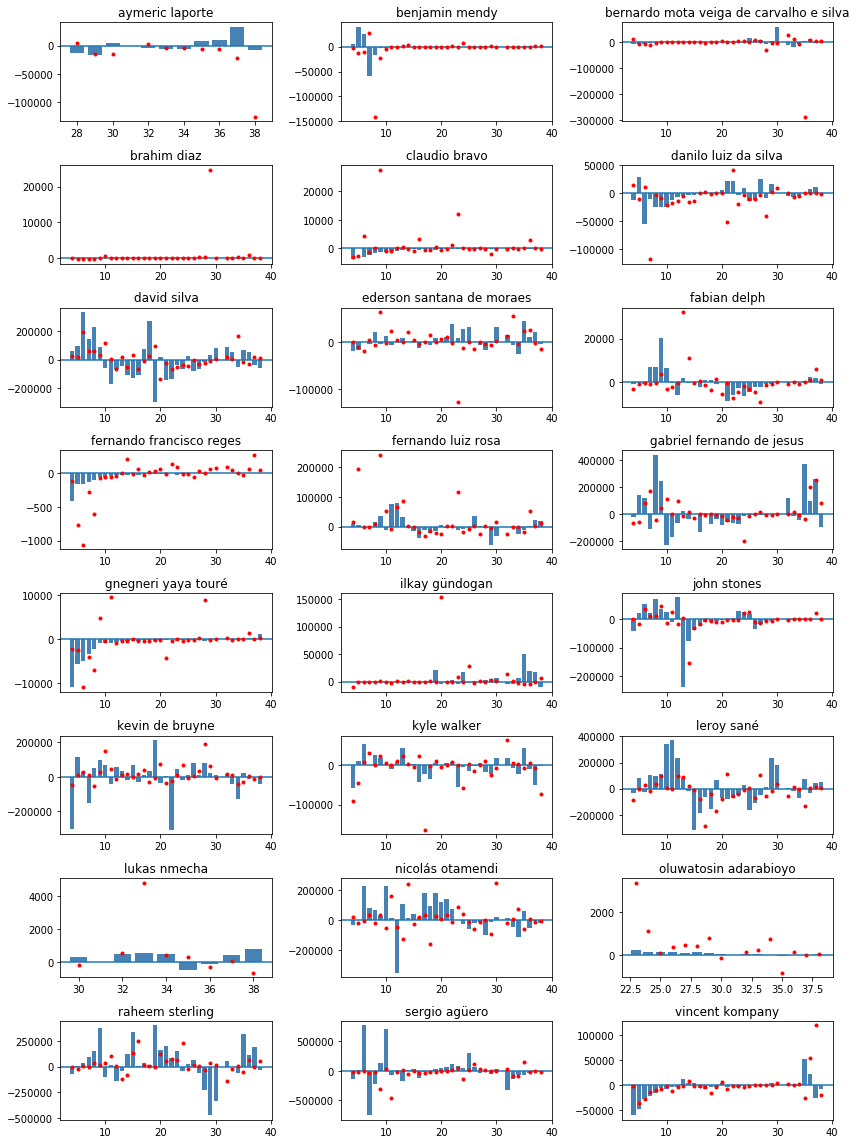

In [36]:
plot_predictions(df, players, y_pred=m0.oob_prediction_)

This naive approach does not peform particulay well in several cases, as it makes the assumption that there is a strong correlation between the previous `transfers_balance` and the current `transfers_balance`. Whilst it is able to track continuous trends (Vincent Kompany), it cannot respond to sharp changes in polarity causes by external factors (an injury? a good performance) and instead tends to make predictions close to the previous value (David Silva).

### Model 1

We will train a second model on a single variable: the lagged version of `points` scored by a player, which will hopefully give us a better response to transfer behaviour based on match performance.

In [37]:
m1 = (RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=0, oob_score=True)
         .fit(df[['points_lag1_ft']] , df['y'])) 

print(rmse(df['y'], m1.oob_prediction_)) 

36658.85960924111


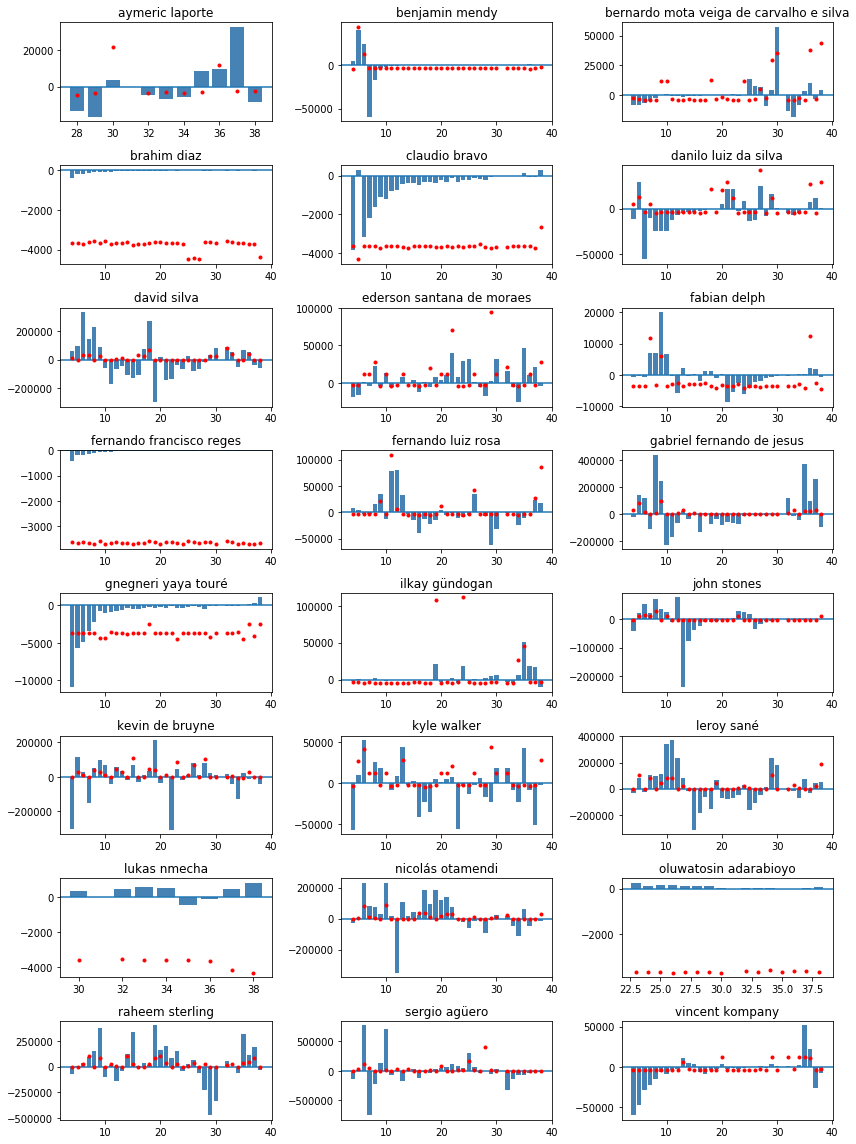

In [38]:
plot_predictions(df, players, y_pred=m1.oob_prediction_)

The RMSE for this model is lower, and we do get a better response to changes in polarity in general, however it has no knowledge of previous trends and in the case where a player does not play (and scores 0 points) it tends to just predict a constant value. Additionally this constant is generic for all players as the model does not capture the "scale" on which a particular players transfers tend to operate.

### Model 2

We will now try adding all the features we created previously and train our full model which will hopefully be able to captures both trends and response events, and apply appropriate scaling to predictions.

In [39]:
m2 = (RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=0, oob_score=True)
         .fit(df[feature_columns] , df['y'])) 

print(rmse(df['y'], m2.oob_prediction_)) 

31443.526711025093


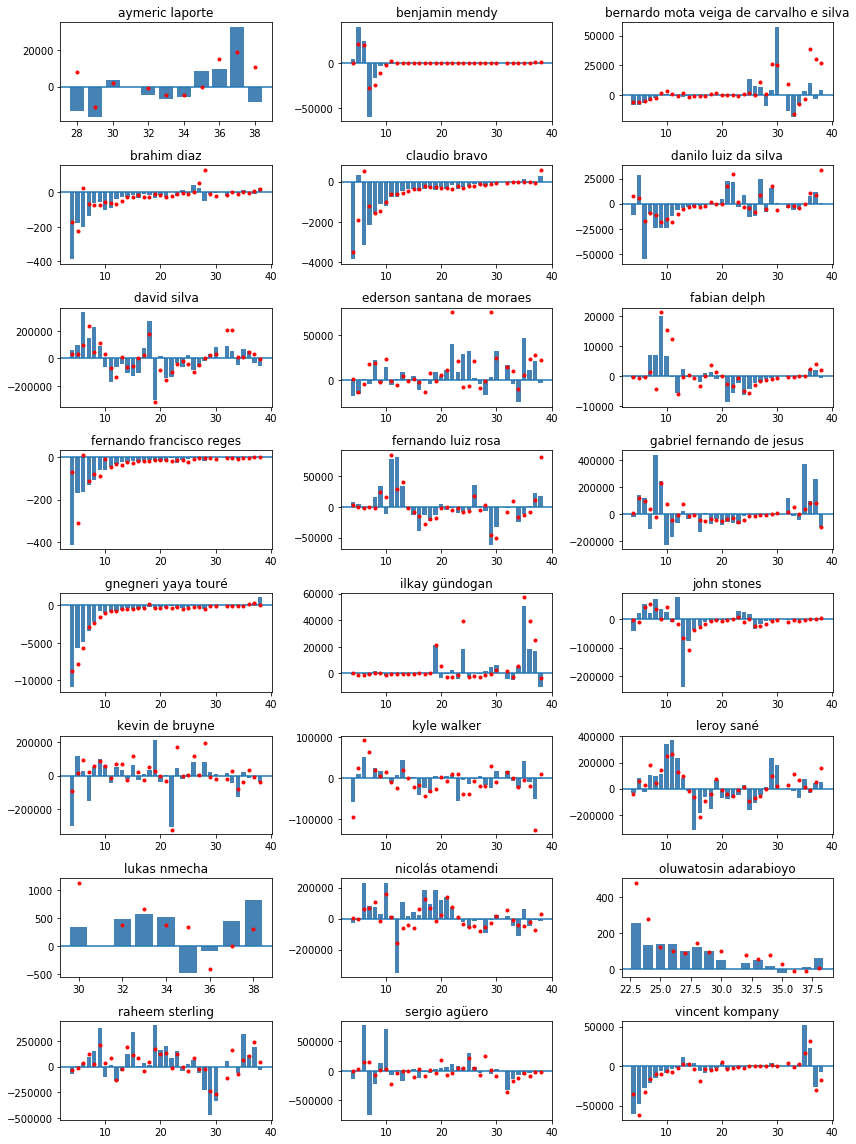

In [40]:
plot_predictions(df, players, y_pred=m2.oob_prediction_) 

We see a drop in RMSE and the visual inspection of predictions suggests they are more appropriate! The response to reverses in polarity are more impressive (David Silva / Nicolas Otamendi), the trends are being tracked more closely and the over scales are appropriate with predictions close to zero where activity is unlikely.

#### Feature importances
Before trying to make further improvements to the model we will first take a look at feature importance to see which features are most predictive, and which could (potentially) be dropped. 

We use the **rfpimp** library to caclulate the **permuted importances** using the oob samples. This works by taking each features in turn, shuffling the order of its values (creating "randomness") and then making predictions and evaluating them. The motivation for this is if a feature is distributed at random and the model preformance (R^2) does not change significantly then it is likely unimportant. The benefit of this method is that we do not have to re-train the model, we are simply affecting the data which we will predict on.

More details on the motivation for the rfpimp library can be found [here](http://parrt.cs.usfca.edu/doc/rf-importance/index.html).

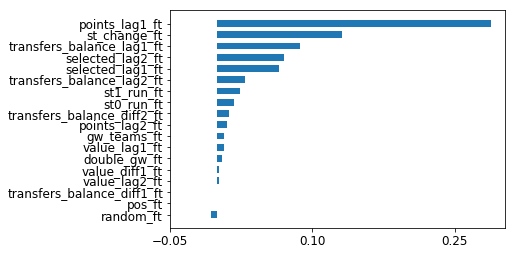

In [41]:
imp = rfpimp.oob_importances(m2, df[feature_columns], df['y'])
rfpimp.plot_importances(imp)

The graph gives us this representation of feature importance by tracking the plotting the change in R^2 with that particular feature permuted. 

Clearly `points` is our strongest feature in predicting net transfers, which is not surprising given that is a large points haul from a player is likely to prompt a number of transfers in, whilst poor scores from a player will see movement in the other direction. 

We also see that the player status `st_` related features are important with a player being injured or suspended also being predictive of transfer activity. 

`selected` is important as the number of teams that currently own a player will impact the level or response to points or status change events. There are more details on `selected` in the introduction notebook but in short if a player already has high ownership there is more flexibility for people to transfer out, whilst transfers in may be limited by a "ceiling" of ownership saturation. The opposite will be true at the opposite end of the scale. 

Knowing the previous `transfer_balance` is also useful data as shown earlier, especially in tracking trends. 

Amongst the least important features are `gw_teams` and `double_gw` which is surprising as it seems intuitive that a player having two games in a gameweek, or playing in a gameweek in which some teams are not playing would influence transfers. It is possible that because these features are quite sparse (nearly always a constant value) that they don't infuence enough records to really affect the *average* performance of the model, despite potentially being predictive. We could also try encoding them in different ways or maybe they are just not that important after all. 

#### Feature correlation 
An important consideration when trying to assess the individual importance of a feature is to try and isolate it from other features which correlate with it (linearly or otherwise). This is because if two or more features are reducing the variance of the errors in the same way it is difficult to quantify the effect of them individually. 

The rfpimp package suggests an approach to try and deal with this. We first produce a correlation matrix (ranked spearman correlation coefficient) to find pairs of features which are correlated. 

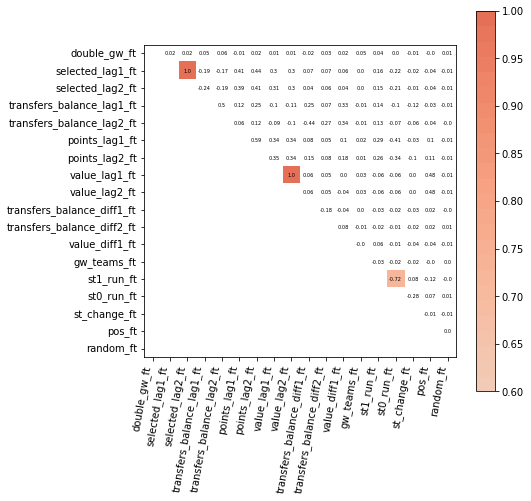

In [42]:
rfpimp.plot_corr_heatmap(df[feature_columns], value_fontsize=5, figsize=(7, 7), label_fontsize=10) 

We then manually group together correlated features and permute them at the same time, essentially treating it as single feature in our feature importance measure.

This "feature grouping" approach is not supported for out-of-bag predictions in rfpimp so we create a train/validation split for this. 

In [43]:
df_train = df.sample(frac=0.8)
df_valid = df.loc[df.index.difference(df_train.index)]

In [44]:
print(df_valid.shape)

(3521, 35)


In [45]:
m2_0 = (RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=0)
         .fit(df_train[feature_columns] , df_train['y'])) 

In [46]:
feat_cor = ['double_gw_ft',
 ['selected_lag1_ft',
 'selected_lag2_ft'] ,
 'transfers_balance_lag1_ft',
 'transfers_balance_lag2_ft' ,
 'points_lag1_ft',
 'points_lag2_ft',
 ['value_lag1_ft',
 'value_lag2_ft'] ,
 'transfers_balance_diff1_ft',
 'transfers_balance_diff2_ft',
 'value_diff1_ft',
 'gw_teams_ft',
 ['st1_run_ft',
 'st0_run_ft'] ,
 'st_change_ft',
 'random_ft']

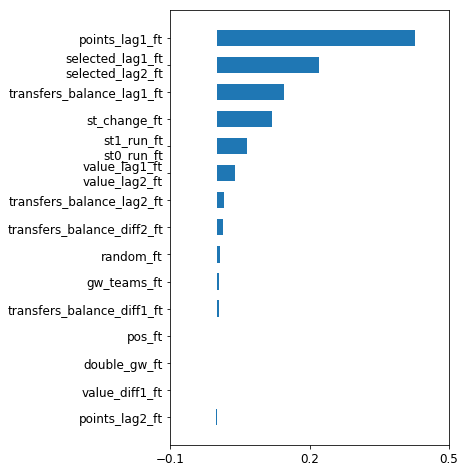

In [47]:
imp = rfpimp.importances(m2_0, df_valid[feature_columns], df_valid['y'], features=feat_cor) 
rfpimp.plot_importances(imp, figsize=(5,8)) 

One of the most noticeable changes we see here is that the `selected` grouped variable importance has increased, which suggests that by permuting the two features separately we were not really capturing their true importance as the performance of the model would never change as significantly as the other feature was still available. 

### Model 3

We will now try to tune some of the hyperparameters in the model by carrying out a grid search over "max_features" and "min_samples_leaf".

"max_features" controls the proportion of features which are considered when making each split. If this is set less than 1.0 then not all features will be available, which should results in less correlated trees, and less variance in our error. This is particularly helpful when you have a very important feature which would otherwise always be the first split point, if it was not removed from some decisions. The effect of this should hopefully be that more subtle patterns described by less important features are still captured by the model. 

By default the "min_samples_leaf" is set to 1 which means that the tree will keep making splits until it has a single observation at each leaf node. By increasing this value we can average over several observations and hopefully return a more stable result. 

In [48]:
%%time
parameters = {
    'min_samples_leaf':np.arange(1,11), 
    'max_features':np.arange(1,11) / 10 # decimal inc was causing precision issue
} 

results = [] 
for p in ParameterGrid(parameters):
    m = (RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=0, oob_score=True, **p)
              .fit(df[feature_columns] , df['y']))
    
    p['rmse'] = rmse(df['y'], m.oob_prediction_)
    results.append(p)

CPU times: user 25min 22s, sys: 1.13 s, total: 25min 23s
Wall time: 25min 41s


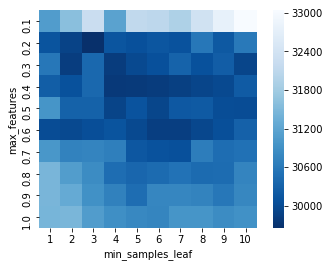

In [49]:
sns.heatmap(pd.DataFrame(results).pivot(index='max_features', columns='min_samples_leaf', values='rmse'), cmap='Blues_r', square=True) 
plt.show()

Grid search results suggest that a "max_features" of around ~0.3 and a "min_samples_leaf" of around ~3 gives us the most improved result. 

At the opposite ends of our search space for "max_features" we see a higher error. When retaining all features, we lose some of the random element of the model and reduced correlation described previously. At the other extreme not retaining enough features is forcing the model to make arbitrary splits on irrelevant features, which may increase the potential to overfit. 

The effect of "min_samples_leaf" is less pronounced but it does appear that that increasing the number of observations at our leaf node (and averaging across them) gives us a more stable prediction, but after a certain point forcing the model to require too many observations means it is unable to make more (potentially necessary) granular splits. 

In [50]:
m3 = (RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=0, oob_score=True, min_samples_leaf=3, max_features=0.3)
         .fit(df[feature_columns] , df['y'])) 

print(rmse(df['y'], m3.oob_prediction_)) 

30390.234491302155


## Interpretation 

We will now start to profile the features included in the model, as well as trying to interpret how they are influencing the target variable and interacting with other features. We start by simply manually "binning" our features and plotting the average response `y` in each of the bins.

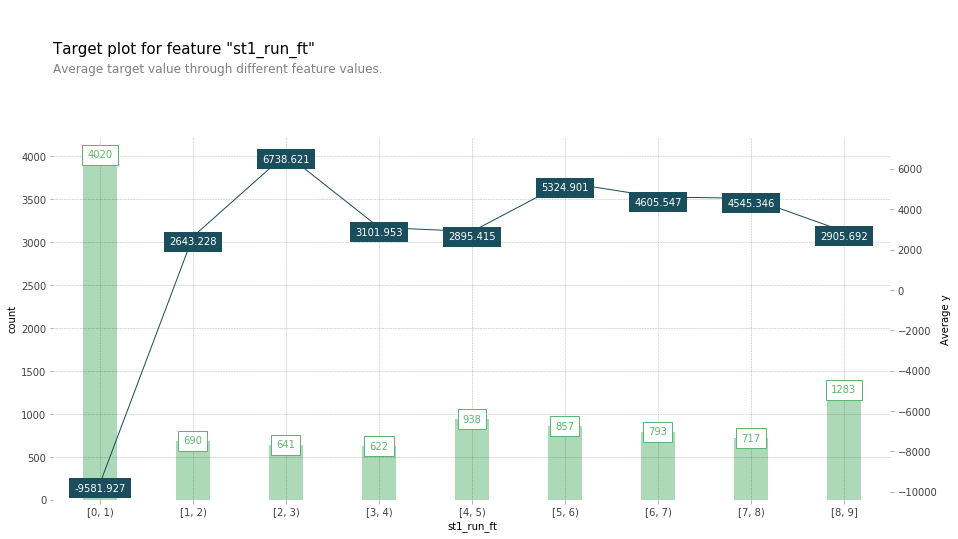

In [51]:
fig, axes, summary_df = info_plots.target_plot(
    df[feature_columns + ['y']],
    feature='st1_run_ft',
    feature_name='st1_run_ft',
    target='y',
    cust_grid_points=range(10)
)

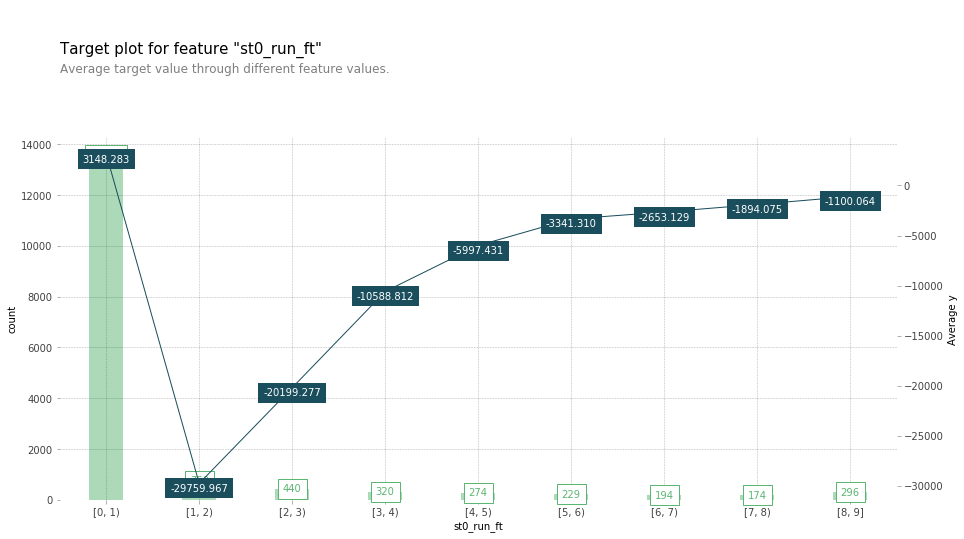

In [52]:
fig, axes, summary_df = info_plots.target_plot(
    df[feature_columns + ['y']],
    feature='st0_run_ft',
    feature_name='st0_run_ft',
    target='y',
    cust_grid_points=range(10)
)

The previous plots show that `st0_run` and `st1_run` are behaving in the way we would expect. To recap `st0_run` records the number of consecutive gameweeks that a player is in a negative status (suspended/injured) whilst `st1_run` shows the opposite: the number of weeks a player has been fit and available.

For example for `st0_run` a value of zero means a player has a negative status, and so on average we set net transfers to be negative. When it is greater than zero we have a positive status, and we see a positive response in trasnfers. After an intial flurry of interest in transferring a player in, the effect of this change in status tends to become less pronounced over time.

The main difference between the two features we can see is that the effect of negative change in status is far more pronounced, both in timing and magnitude. When a player received a negative status then the response in immediate with people moving to transfer them out. In contrast the response in `st1_run` is slower and peaks in the second week, whilst the difference in magnitude is emphasised by the `st_change` feature shown below which is simply a flag which captures both positive and negative status changes (-1 = negative change, 0 = no change, 1 = positive change).

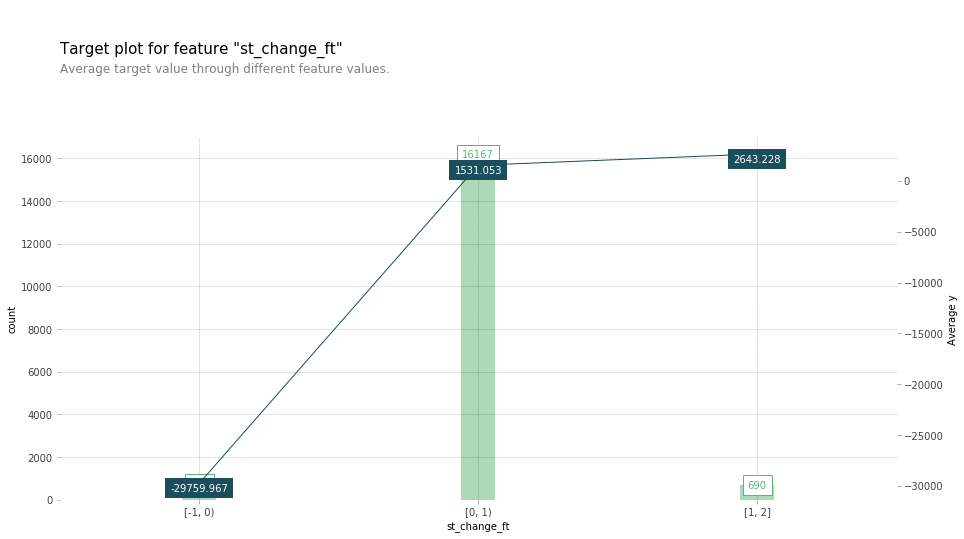

In [53]:
fig, axes, summary_df = info_plots.target_plot(
    df[feature_columns + ['y']],
    feature='st_change_ft',
    feature_name='st_change_ft',
    target='y',
    cust_grid_points=range(-1,3)
)

The reason for this slower, weaker response to positive status changes could be attributed to a combination of factors:
1. User are not "obliged" to sign players that have a positive change in status, in the same way that they almost certainly want to remove a player that has become unavailable 
2. Users may not be aware of a positive status change, unlike a negative one which is displayed on their team dashboard
3. Users may be apprehensive about signing a player that is newly available as they may start on the bench as their minutes are managed

Also notice that the relationship for the `st_run` features are clearly non-monotonic, and this is something we will hopefully be able to capture with our Random Forest, which would not be possible with a linear model, without one-hot encoding our values as categories.

We will now consider our most important feature: `points`

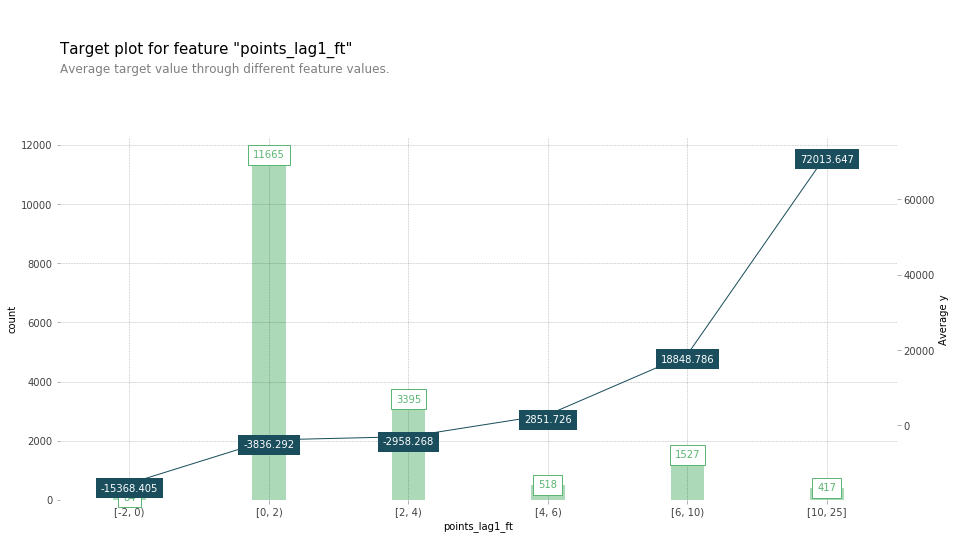

In [54]:
fig, axes, summary_df = info_plots.target_plot(
    df[feature_columns + ['y']],
    feature='points_lag1_ft',
    feature_name='points_lag1_ft',
    target='y', 
    cust_grid_points=[-2,0,2,4,6,10,25] 
)

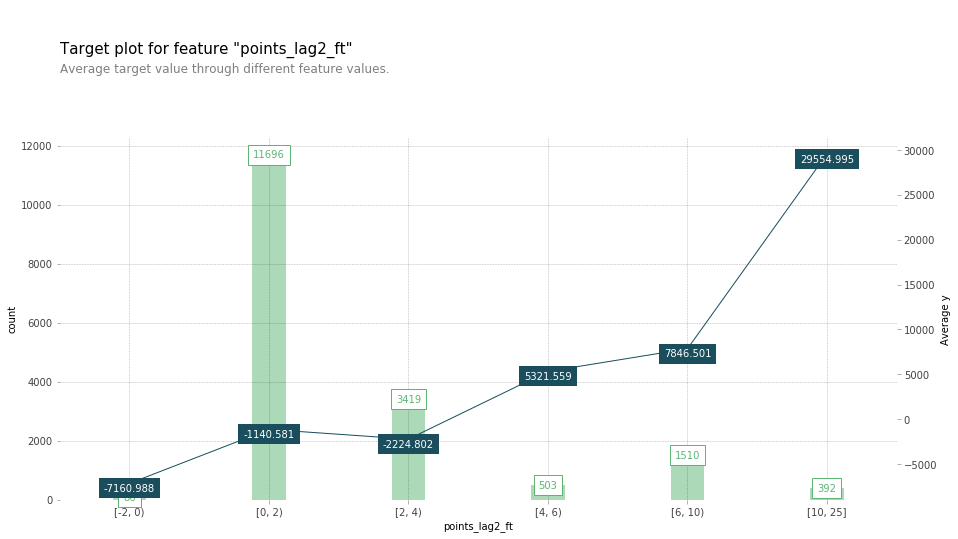

In [55]:
fig, axes, summary_df = info_plots.target_plot(
    df[feature_columns + ['y']],
    feature='points_lag2_ft',
    feature_name='points_lag2_ft',
    target='y', 
    cust_grid_points=[-2,0,2,4,6,10,25] 
)

We can clearly see the direct relationship between increase in points and increase in net transfers. The effect is visible with both lags, but less pronounced for a lag of two weeks, which is intuitive. 


#### Partial dependencies plots
The previous plots give us an indication of how we might expect our features to perform and in what direction they will influence our response. However without training a model we do not know how well it will actually be able to capture the these apparent effects, and to what extent the "trends" are actually being influenced by interactions with other features. 

The main output of the **pdpbox** package is designed to give us a better insight in to what might otherwise be a black box. It does this through **partial dependency plots** which also look to visualize the variation in response at different levels of a chosen feature, and works by taken a trained model and predicting on dummy records. These records have all feature values preserved except from our feature of interest which is replaced with a constant value. This is repeated for a range of constants and the results plotted. In the images below each line represents a single record in the input data. 

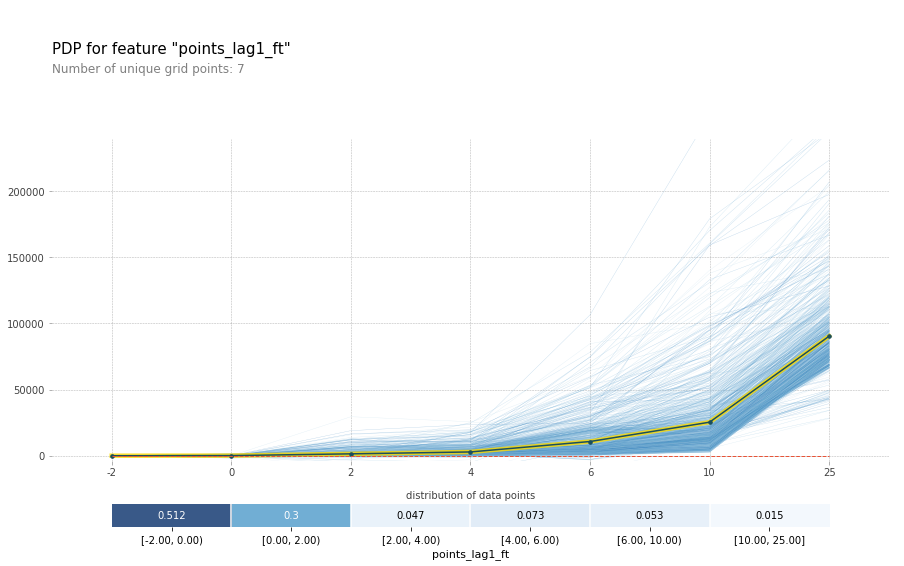

In [56]:
pdp_iso = pdp.pdp_isolate(
    model=m3, 
    dataset=df[feature_columns].sample(1000, random_state=0),
    model_features=feature_columns,
    feature='points_lag1_ft', 
    cust_grid_points=[-2,0,2,4,6,10,25]
) 

fig, axes = pdp.pdp_plot(
    pdp_isolate_out=pdp_iso,
    feature_name='points_lag1_ft',
    plot_lines=True, 
    plot_pts_dist=True, 
    center=True, 
    x_quantile=True
)
plt.show() 

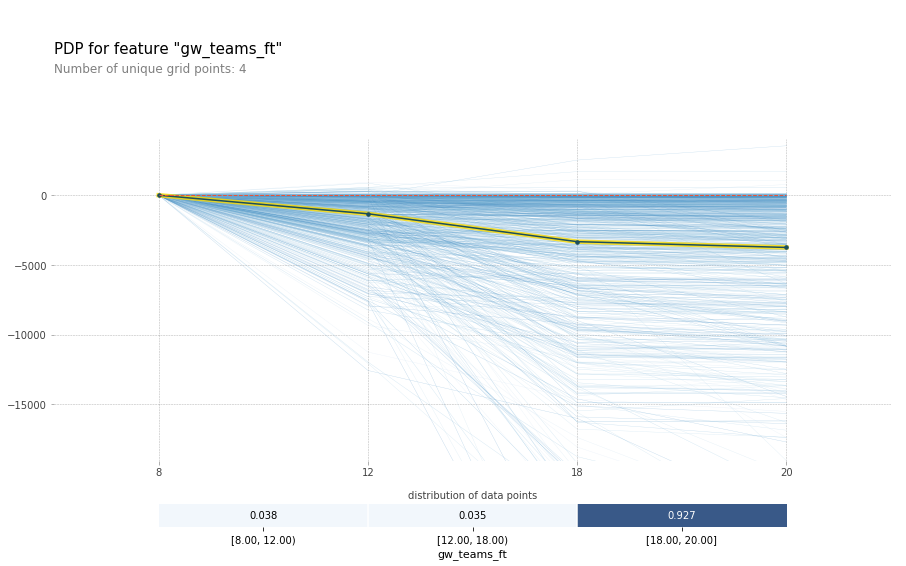

In [57]:
pdp_iso = pdp.pdp_isolate(
    model=m3, 
    dataset=df[feature_columns].sample(1000, random_state=0),
    model_features=feature_columns,
    feature='gw_teams_ft', 
    cust_grid_points=df['gw_teams_ft'].unique() 
) 

fig, axes = pdp.pdp_plot(
    pdp_isolate_out=pdp_iso,
    feature_name='gw_teams_ft',
    plot_lines=True, 
    plot_pts_dist=True, 
    center=True, 
    x_quantile=True
)
plt.show() 

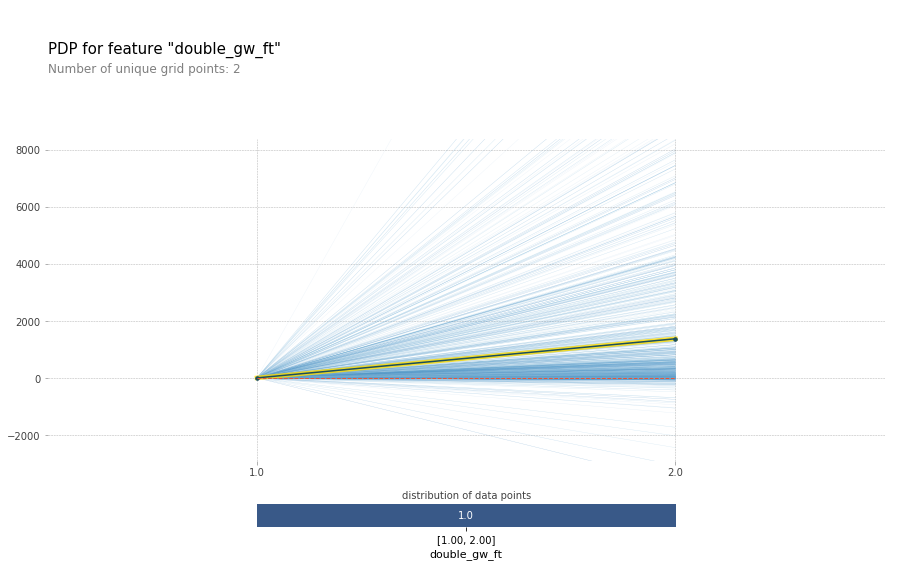

In [58]:
pdp_iso = pdp.pdp_isolate(
    model=m3, 
    dataset=df[feature_columns].sample(1000, random_state=0),
    model_features=feature_columns,
    feature='double_gw_ft', 
) 

fig, axes = pdp.pdp_plot(
    pdp_isolate_out=pdp_iso,
    feature_name='double_gw_ft',
    plot_lines=True, 
    plot_pts_dist=True, 
    center=True, 
    x_quantile=True
)
plt.show() 

We can see that this attempt at isolating the dependency of our modelled target variable on our `points` feature has produced a distribution similar to the one we were seeing in our previous plot. Note that observation lines have been centered on their first values to allow an easier comparison of trends between lines, so the positive/negative on the y-axis is not necessarily representing a net transfers in or out

We also show `double_gw` and `gw_teams` which previously were flagged as being relatively unimportant, but here assuming all other things equal and only modifying them, they do move in the direction would would hope. That is, when a player has a double gameweek (2) then we get a positive shift in `transfers_balance` and when there are fewer teams playing in a gameweek we also see a positive shift. 

Another interesting feature of the **pdpbox** library is the ability to plot partial dependencies using pairs of features to highlight interaction effects.

#### Interaction plots

We will compare the effect of our strongest feature (`points`) in combination with a selection of other features. 

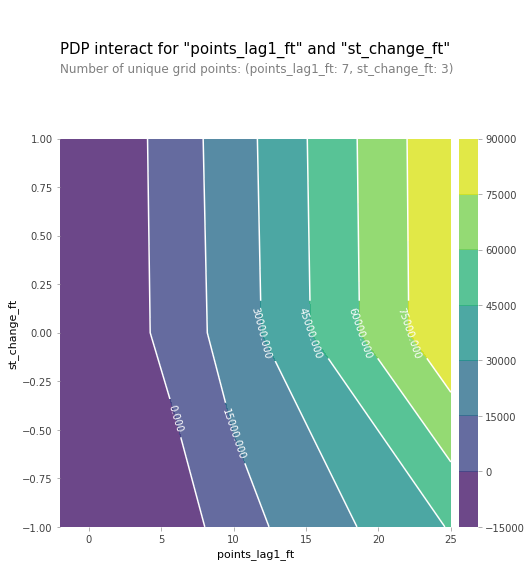

In [59]:
int_features = ['points_lag1_ft', 'st_change_ft']
pdp_int = pdp.pdp_interact(
    model=m3,
    dataset=df[feature_columns].sample(1000, random_state=0),
    model_features=feature_columns, 
    features=int_features, 
    cust_grid_points=[[-2,0,2,4,6,10,25], None] 
)

fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out=pdp_int,
    feature_names=int_features, 
) 
plt.show()

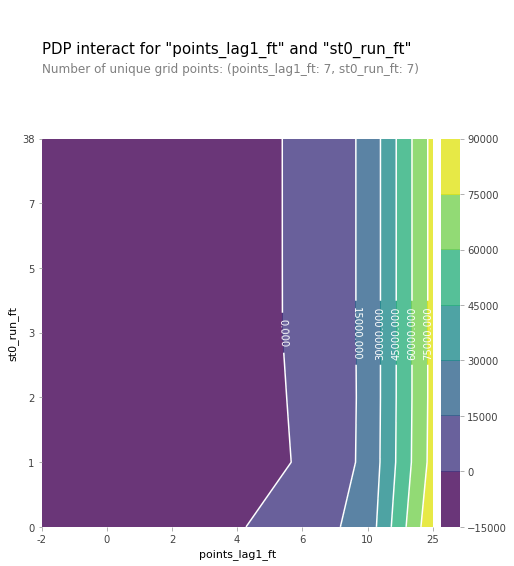

In [60]:
int_features = ['points_lag1_ft', 'st0_run_ft']
pdp_int = pdp.pdp_interact(
    model=m3,
    dataset=df[feature_columns].sample(1000, random_state=0),
    model_features=feature_columns, 
    features=int_features, 
    cust_grid_points=[[-2,0,2,4,6,10,25], [0,1,2,3,5,7,38]] 
)

fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out=pdp_int,
    feature_names=int_features, 
    x_quantile=True
) 
plt.show()

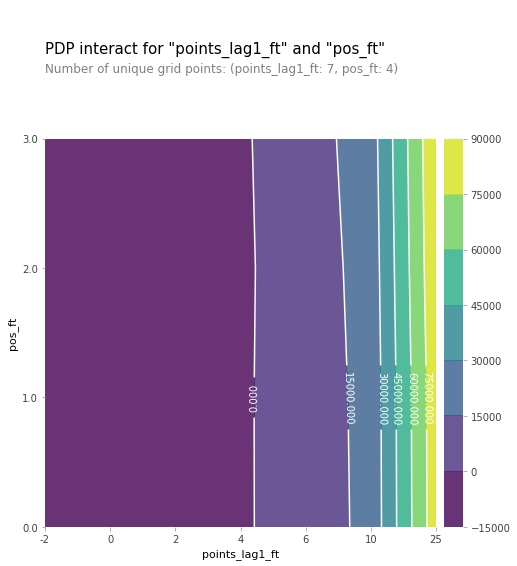

In [61]:
int_features = ['points_lag1_ft', 'pos_ft']
pdp_int = pdp.pdp_interact(
    model=m3,
    dataset=df[feature_columns].sample(1000, random_state=0),
    model_features=feature_columns, 
    features=int_features, 
    cust_grid_points=[[-2,0,2,4,6,10,25], None] 
)

fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out=pdp_int,
    feature_names=int_features, 
    x_quantile=True
) 
plt.show()

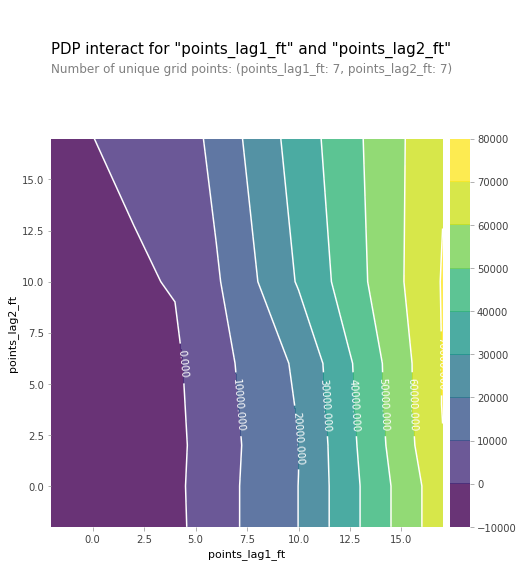

In [62]:
int_features = ['points_lag1_ft', 'points_lag2_ft']
pdp_int = pdp.pdp_interact(
    model=m3,
    dataset=df[feature_columns].sample(1000, random_state=0),
    model_features=feature_columns, 
    features=int_features, 
    cust_grid_points=[[-2,0,2,4,6,10,17], [-2,0,2,4,6,10,17]] 
)

fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out=pdp_int,
    feature_names=int_features
) 
plt.show()

Of the combinations we have tested the most unusual result comes from the interaction between `points_lag1_ft` and `points_lag2_ft`. Whilst the combination is fairly linear for the lower points totals we see a sudden increase when we hit 10 points. Whilst this is not necessarily an interaction between the two variables, as both increase non-linearly, it could suggest that the combination of consecutive weeks of high points totals may have a more significant effect on the response, than the sum of their parts, but this would require more testing. 

However the unusual part is that after 10 points the effect seems to plateau. A likely explanation for this is that the plot does not reflect "reality" as it is trying to make predictions in an extremely sparse part of our feature space as it is very rare for a player to score ~15 points in consecutive weeks. This means the predictions we are seeing are likely not that stable and is a known issue with the partial dependency plot method. 

#### Interpretting individual preditions

As well as gaining insight into how features are performing on the dataset overall, it can also be useful to break down the individual components of a single prediction. Unlike a linear model which is simply a series of weighted additions, the Random Forest is less easy to interpret directly. One approach is using **treeinterpreter** prediction decomposition which sums up the change in prediction each split in the tree made, and aggregates features across all trees. From this we get a proportional contribution to the final prediction for each feature which can be useful in "debugging" a model, or just understanding how a particular prediction was made.

We will look at an example for a single player.

In [78]:
df_train = df.loc[df['player_name'] != 'david silva']
df_valid = df.loc[df.index.difference(df_train.index)]

m = (RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0, min_samples_leaf=3, max_features=0.3)
         .fit(df_train[feature_columns] , df_train['y'])) 


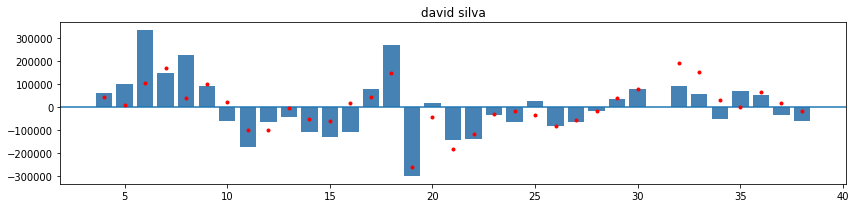

In [79]:
plot_predictions(df_valid, ['david silva'], y_pred=m.predict(df_valid[feature_columns]), n_cols=1, height=3) 

One of the most siginficant parts of the season is the polarizing spikes in **GW18** and **GW19**. By looking at the contributions we can see if they line up with our intuition, and the features themselves.

In [65]:
prediction, bias, contributions = ti.predict(m, df_valid[feature_columns])

In [66]:
df_contrib = pd.DataFrame(contributions.T, index=feature_columns, columns=df_valid['gw'])

df_contrib.loc[:,15:22].style.background_gradient(axis=0, cmap='coolwarm')

gw,15,16,17,18,19,20,21,22
double_gw_ft,-101.428,-138.57,-149.796,-1291.39,-164.238,-138.538,0,-138.538
selected_lag1_ft,-6099.33,2049.74,2767.01,9018.6,-27173.8,4480.33,-47499.6,-9836.28
selected_lag2_ft,-4642.55,2311.21,918.529,5738.91,-50265.2,-5363.09,-17256,-15585.5
transfers_balance_lag1_ft,-32884.6,-24670.6,-13662.2,25976.1,-41248.6,-47223.8,1605.24,-34376.2
transfers_balance_lag2_ft,-3139.74,-4506.84,-1164.17,-7142.75,-11189.3,-1225.82,2157.82,-1142.63
points_lag1_ft,-9466.94,38905.2,33230.6,86372.5,-8239.51,-9637.25,-3854.7,-4941.88
points_lag2_ft,-1043.04,-2975.13,15395,-1330.44,-1717.79,-1235.99,-1734.44,2016.67
value_lag1_ft,-4700.56,2827.08,1565.95,1342.57,-16176,-2764.96,-4548.11,137.289
value_lag2_ft,-2855.87,6792.09,5041.37,7882.56,-13695.4,-2104.01,-20034.1,-2470.83
transfers_balance_diff1_ft,-1705.55,-1560.59,-3550.22,16383.9,-8773.13,-12510.8,-8149.55,-16832


Feature values

In [67]:
(df_valid.set_index('gw')
         .loc[15:22, feature_columns]
         .T
         .style.background_gradient(axis=1, cmap='coolwarm'))

gw,15,16,17,18,19,20,21,22
double_gw_ft,1,1,1,1,1,1,1,1
selected_lag1_ft,1.02733e+06,901247,794119,875630,1.1525e+06,853543,875008,733201
selected_lag2_ft,1.13256e+06,1.02733e+06,901247,794119,875630,1.1525e+06,853543,875008
transfers_balance_lag1_ft,-106775,-127561,-109065,78211,269312,-300681,17952,-143675
transfers_balance_lag2_ft,-45002,-106775,-127561,-109065,78211,269312,-300681,17952
points_lag1_ft,1,9,8,16,0,3,0,0
points_lag2_ft,1,1,9,8,16,0,3,0
value_lag1_ft,83,82,81,81,83,82,82,82
value_lag2_ft,84,83,82,81,81,83,82,82
transfers_balance_diff1_ft,-61773,-20786,18496,187276,191101,-569993,318633,-161627


By plotting a snapshot around our weeks of interest we can get an idea of unusual activity. In GW18 `points` has a very high relative contribution, along with `transfers_balance`. The second DataFrame (above) showing the raw feature values agrees with this: A very high score of 16 points in the previous week, add to an already increasing trend in transfers in.

GW19 sees strong relative contributions from `st_change` which we can again confirm as a negative status change, likely an injury. We also see strong contributions from `selected`, which acts as a "calibrator" for the level of change, but also `transfers_balance` lag has a large negative contirbution despite the feature value itself being large and positive.

This is very interesting and implies that a positive "trend" in `transfers_balance` is not simply extraploated by the model, rather it acts as a "calibrator" in a similar way to `selected`. In other words, we seeing a large increase in transfers followed by a negative change in status predicts a *larger* shift in the other direction, than if we had not seen the initial upwards trend.

This rebound effect is confirmed in the interaction plot below which, for negative status in particular, show more of a negative shift when we have a larger positive net change in transfers in the previous week `transfers_balance_lag1` than if the net transfers was close to zero. Intuitively this makes sense as impulsive transfer activity in one particular direction is more likely to reverse drastically, than say a more gradual uptake in ownership of a player.  You could even say in a very crude sense that the model has some form of short term "memory" which can rebalance strong changes in a particular direction.

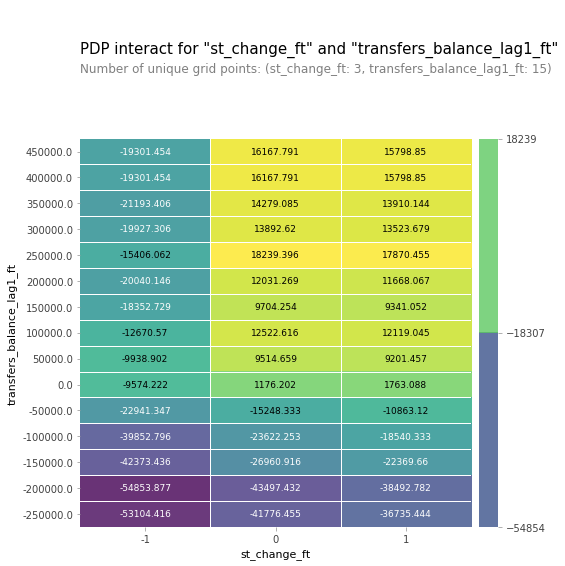

In [68]:
int_features = ['st_change_ft', 'transfers_balance_lag1_ft']
pdp_int = pdp.pdp_interact(
    model=m3,
    dataset=df[feature_columns].sample(1000, random_state=0),
    model_features=feature_columns, 
    features=int_features,
    cust_grid_points=[[-1,0,1], np.arange(-25e4, 50e4, 5e4)] 
)

fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out=pdp_int,
    feature_names=int_features, 
    plot_type='grid'
) 
plt.show()

## Model 4

We finish up by increasing the number of trees in the model to find the optimum size of the forest

In [75]:
results = [] 
test_n_trees = [10,20,30,40,50,75,100,125,150,175, 200]
for n_trees in test_n_trees:
    m = (RandomForestRegressor(n_estimators=n_trees, n_jobs=-1, random_state=0, oob_score=True, min_samples_leaf=3, max_features=0.3)
             .fit(df[feature_columns] , df['y'])) 

    results.append(rmse(df['y'], m.oob_prediction_)) 

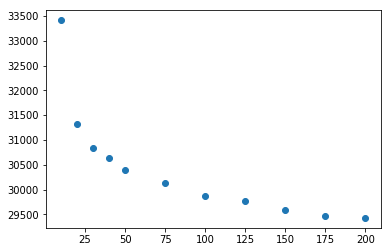

In [76]:
plt.scatter(x=test_n_trees, y=results) 
plt.show() 

In [81]:
m4 = (RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=0, oob_score=True, min_samples_leaf=3, max_features=0.3)
             .fit(df[feature_columns] , df['y'])) 

print(rmse(df['y'], m4.oob_prediction_)) 

29429.994085100418


### Next steps...
* Test on new season
* LightGBM gradient boosting
* Sequence models: CRF, LSTM RNN
* Try combining separate models for `tranfers_in` / `transfers_out`